# Analyze OpenStreetMap Data with SQL

*Connie Hsiao*

## Introduction

OpenStreetMap (OSM) is a collaborative project to create a free editable map of the world. In this project, I will use the CSV file which is extracted from OSM and explore the dataset with SQL queries.

## Map Area 

** Boston, Massachusetts, US** https://mapzen.com/data/metro-extracts/metro/boston_massachusetts/

## Create SQL database from CSV files

In [1]:
# Creates the SQL database

import sqlite3
import pprint
import csv

conn=sqlite3.connect('boston.db')
conn.text_factory = str
cur=conn.cursor()

### nodes Table

In [41]:
# Creates the "nodes" table in the database

cur.execute('''CREATE TABLE nodes(
    id INTEGER PRIMARY KEY NOT NULL,
    lat REAL,
    lon REAL,
    user TEXT,
    uid INTEGER,
    version INTEGER,
    changeset INTEGER,
    timestamp TEXT);''') 

In [98]:
# Inserting values to the "nodes" table from CSV files
with open('nodes.csv', 'rb') as table:
    dicts = csv.DictReader(table)
    to_db = ((i['id'], i['lat'],i['lon'],i['user'],i['uid'],i['version'],i['changeset'],i['timestamp']) for i in dicts) 
    cur.executemany("INSERT INTO nodes (id, lat, lon, user, uid, version, changeset, timestamp) VALUES (?,?,?,?,?,?,?,?);", to_db)
conn.commit()

### nodes_tags Table

In [57]:
# Creates the "nodes_tags" table in the database
cur.execute('''CREATE TABLE nodes_tags (
    id INTEGER,
    key TEXT,
    value TEXT,
    type TEXT,
    FOREIGN KEY (id) REFERENCES nodes(id));''') 

In [58]:
# Inserting values to the "nodes_tags" table from CSV files
with open ('nodes_tags.csv', 'rb') as table:
    dicts = csv.DictReader(table)
    to_db = ((i['id'], i['key'],i['value'],i['type']) for i in dicts)  
    cur.executemany("INSERT INTO nodes_tags (id, key,value,type) VALUES (?,?,?,?);", to_db)
conn.commit()

In [168]:
#Test if the insertion is successful
query = ''' SELECT * FROM nodes_tags limit 5; 
'''
result=cur.execute(query).fetchall()
print result

[(31419556, 'name', 'Firebrand Saints', 'regular'), (31419556, 'amenity', 'restaurant', 'regular'), (31419650, 'url', 'http://www.mbta.com/schedules_and_maps/subway/lines/stations/?stopId=12412', 'regular'), (31419650, 'name', 'Kendall/MIT', 'regular'), (31419650, 'railway', 'subway_entrance', 'regular')]


### ways Table

In [61]:
# Creates the "ways" table in the database
cur.execute('''CREATE TABLE ways(
id INTEGER PRIMARY KEY NOT NULL,
user TEXT,
uid INTEGER,
version TEXT,
changeset INTEGER,
timestamp, TEXT);''' )

In [64]:
# Inserting values to the "ways" table from CSV files
with open ('ways.csv','rb') as table:
    dicts=csv.DictReader(table)
    to_db=((i['id'],i['user'],i['uid'],i['version'],i['changeset'],i['timestamp'])for i in dicts)
    cur.executemany("INSERT INTO ways (id,user,uid,version,changeset,timestamp) VALUES (?,?,?,?,?,?);",to_db)
conn.commit()


In [169]:
#check if the insertion is successful 
for row in cur.execute("pragma table_info('nodes_tags')").fetchall():
    print row

(0, 'id', 'INTEGER', 0, None, 0)
(1, 'key', 'TEXT', 0, None, 0)
(2, 'value', 'TEXT', 0, None, 0)
(3, 'type', 'TEXT', 0, None, 0)


### ways_tags Table

In [67]:
# Creates the "ways_tags" table in the database
cur.execute('''CREATE TABLE ways_tags(
    id INTEGER NOT NULL,
    key TEXT NOT NULL,
    value TEXT NOT NULL,
    type TEXT,
    FOREIGN KEY (id) REFERENCES ways (id));''')

In [68]:
# Inserting values to the "ways_tags" table from CSV files
with open ('ways_tags.csv','rb') as table:
    dicts=csv.DictReader(table)
    to_db=((i['id'],i['key'],i['value'],i['type'])for i in dicts)
    cur.executemany ("INSERT INTO ways_tags (id, key, value, type) VALUES (?,?,?,?);", to_db)
conn.commit()


### ways_nodes Table

In [74]:
# Creates the "ways_nodes" table in the database
cur.execute('''CREATE TABLE ways_nodes(
    id INTEGER NOT NULL,
    node_id INTEGER NOT NULL,
    position INTEGER NOT NULL,
    FOREIGN KEY (id) REFERENCES ways (id),
    FOREIGN KEY (node_id) REFERENCES nodes(id));''')

In [75]:
# Inserting values to the "ways_nodes" table from CSV files

with open ('ways_nodes.csv', 'rb') as table:
    dicts=csv.DictReader(table)
    to_db=((i['id'], i['node_id'],i['position']) for i in dicts) 
    cur.executemany("INSERT INTO ways_nodes(id, node_id,position) VALUES (?,?,?);", to_db)
conn.commit()

## Data Overview

### Tables in the Database

In [3]:
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cur.fetchall())

[('nodes_tags',), ('ways',), ('ways_tags',), ('ways_nodes',), ('nodes',)]


### Data Size

In [4]:
import os
files_lst = ['nodes.csv', 'nodes_tags.csv', 'ways.csv', 'ways_tags.csv', 'ways_nodes.csv']
for i in files_lst: 
    print "file {!r} is {!s} MB".format(i,round(os.path.getsize(i)/(1024*1024.0),1))


file 'nodes.csv' is 151.8 MB
file 'nodes_tags.csv' is 16.9 MB
file 'ways.csv' is 20.0 MB
file 'ways_tags.csv' is 21.5 MB
file 'ways_nodes.csv' is 52.3 MB


### Number Of Nodes

In [5]:
query ='''
SELECT count(*) FROM nodes;
'''
result = cur.execute(query).fetchall()
print result [0][0]


1931442


There are 1,931,442 nodes in the data.

### Number Of Ways

In [6]:
query ='''
SELECT count(*) FROM ways;
'''
result=cur.execute(query).fetchall()
print result[0][0]

309066


There are 309,066 ways.

## Data Exploration

This section focus on the analytics about the dataset; using SQL queries to gather the statistics.


### Number Of Unique Users

In [7]:
query ='''
SELECT COUNT(uid) FROM (SELECT uid from nodes UNION SELECT uid from ways)
'''
result=cur.execute(query).fetchall()
print result[0][0]

1295


There are 1,295 users contributed to the the data. 

### Number of Schools

In [8]:
query = ''' SELECT COUNT(*) FROM nodes_tags WHERE value = 'school'

'''
result=cur.execute(query).fetchall()
print result[0][0]

515


There are 515 schools in this district.

### Top 10 Contributing Users 

In [9]:
query ='''SELECT uid, user, COUNT(*) as SUM FROM (SELECT uid, user FROM nodes UNION ALL SELECT uid, user FROM ways) 
GROUP BY uid ORDER BY sum DESC LIMIT 10;
'''
result =cur.execute(query).fetchall()
for a, b, c in result:
    print a, b ,':', c

1034 crschmidt : 1202965
1137433 jremillard-massgis : 430112
354704 OceanVortex : 92067
326503 wambag : 80064
221294 morganwahl : 69535
3216582 ryebread : 67063
15750 MassGIS Import : 63277
1137518 ingalls_imports : 32461
81285 Ahlzen : 27154
165061 mapper999 : 14967


### Number of Users With Only 1 Contribution

In [10]:
query =''' SELECT COUNT(*) FROM (SELECT uid, user, COUNT(*) as sum FROM (SELECT uid, user FROM nodes UNION ALL SELECT uid, user FROM ways) 
GROUP BY uid HAVING sum = 1);
'''
result=cur.execute(query).fetchall()
print result [0][0]


355


There are 355 users who contribute only 1 entry, among the total 1295 users.

### Cities Other Than Boston

In [11]:
query = ''' SELECT value, COUNT(*) as sum FROM (SELECT * FROM nodes_tags UNION SELECT * FROM ways_tags)
WHERE key = 'city' and NOT value LIKE 'Boston' 
GROUP BY value ORDER BY sum DESC LIMIT 10;
'''
row=cur.execute(query).fetchall()
print 'The top 10 "Non-Boston" cities with most records:'
for a, b in row: 
    print a, ':', b

query='''SELECT COUNT(*) FROM (SELECT value, COUNT(*) as sum FROM (SELECT * FROM nodes_tags UNION SELECT * FROM ways_tags)
WHERE key = 'city' and NOT value LIKE 'Boston' 
GROUP BY value ) as sub;'''

result= cur.execute(query).fetchall()

print'The numbers of the cities other than Boston in the data:', result[0][0]
                    

The top 10 "Non-Boston" cities with most records:
Cambridge : 556
Malden : 413
Arlington : 285
Somerville : 245
Jamaica Plain : 96
Quincy : 55
Chelsea : 43
Brookline : 40
Medford : 34
Weymouth : 34
The numbers of the cities other than Boston in the data: 49


### Top Postal Codes

In [12]:
query='''SELECT value, COUNT(*) as SUM FROM (SELECT * FROM nodes_tags UNION SELECT * FROM ways_tags)
WHERE key= 'postcode'
GROUP BY value
ORDER BY SUM DESC LIMIT 10;
'''

result=cur.execute(query).fetchall()
for a,b in result:
    print a, ':', b


02139 : 431
02135 : 268
02130 : 182
02134 : 162
02474 : 133
02144 : 117
02138 : 97
02114 : 86
02143 : 67
02145 : 64


###  Amenities By Count

In [42]:
query =''' SELECT value, COUNT(*) as sum FROM nodes_tags WHERE key= 'amenity'
GROUP BY value HAVING sum > 9 ORDER BY sum DESC 
'''
result=cur.execute(query).fetchall()
print 'The amenities with more than 10 entries:'
for a, b in result:
    print a, ':', b


The amenities with more than 10 entries:
bench : 1060
restaurant : 602
school : 509
place_of_worship : 287
library : 280
bicycle_parking : 273
cafe : 248
fast_food : 184
bicycle_rental : 138
post_box : 114
waste_basket : 95
fire_station : 89
parking : 86
hospital : 77
bank : 76
fountain : 67
fuel : 65
pub : 60
atm : 54
bar : 52
pharmacy : 45
post_office : 45
police : 43
drinking_water : 40
toilets : 40
car_sharing : 36
bicycle_repair_station : 29
theatre : 23
grave_yard : 18
recycling : 17
telephone : 17
university : 17
ferry_terminal : 16
car_rental : 13
college : 12
parking_entrance : 12
townhall : 10


The top 5 aminities with most records in descending order are: Bench, Restaurant, school, place of worship and library.

### Most Popular Cuisines 

In [14]:
query = ''' SELECT value, count(*) as sum FROM nodes_tags, 
(SELECT DISTINCT(id) FROM nodes_tags WHERE value = 'restaurant')as sub
WHERE nodes_tags.id = sub.id and nodes_tags.key = 'cuisine' 
GROUP BY value ORDER BY sum DESC LIMIT 10;
'''
result= cur.execute(query).fetchall()
for a, b in result:
    print a,':', b

pizza : 38
american : 35
italian : 31
chinese : 29
mexican : 27
indian : 21
thai : 19
asian : 13
japanese : 12
regional : 12


The top 5 most popular cuisines in descending order are: Pizza, American, Italian, Chinese and Mexican

Populating the interactive namespace from numpy and matplotlib


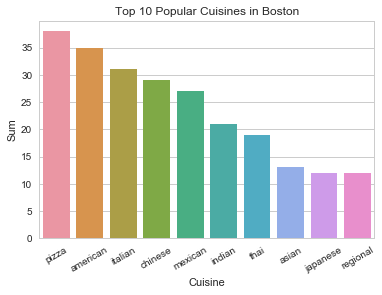

In [38]:
import pandas as pd
import seaborn as sns
from sqlalchemy import create_engine

%pylab inline

disk_engine = create_engine('sqlite:///boston.db')

df = pd.read_sql_query('SELECT value, count(*) as sum FROM nodes_tags,' 
'(SELECT DISTINCT(id) FROM nodes_tags WHERE value = "restaurant")as sub '
'WHERE nodes_tags.id = sub.id and nodes_tags.key = "cuisine" ' 
'GROUP BY value ORDER BY sum DESC LIMIT 10;', disk_engine)

sns.set_style("whitegrid")
plot1= sns.barplot(x="value", y="sum", data=df)
plot1.set_xticklabels(plot1.get_xticklabels(), rotation=30)
plot1.set(xlabel='Cuisine', ylabel='Sum')
plot1.set_title('Top 10 Popular Cuisines in Boston')

### Religion Practice

In [245]:
query = ''' SELECT value, COUNT(*) as sum FROM nodes_tags,
(SELECT DISTINCT(id) FROM nodes_tags WHERE value = 'place_of_worship') as sub
WHERE nodes_tags.id = sub.id AND key = 'religion'
GROUP BY value
ORDER BY sum DESC;
'''
result=cur.execute(query).fetchall()

for a, b in result:
    print a, ':', b


christian : 255
jewish : 10
unitarian : 3
buddhist : 1
muslim : 1
unitarian_universalist : 1


### Popular Banks

In [261]:
query = ''' SELECT value,COUNT(*) AS SUM FROM nodes_tags 
WHERE key='name' and value LIKE '%Bank%' 
GROUP BY value
ORDER BY SUM DESC LIMIT 10
'''
result=cur.execute(query).fetchall()
for a, b in result:
    print a,":", b

Bank of America : 15
Citizens Bank : 10
Eastern Bank : 5
TD Bank : 5
Cambridge Savings Bank : 3
Citibank : 3
Brookline Bank : 2
East Boston Savings Bank : 2
Leader Bank : 2
People's United Bank : 2


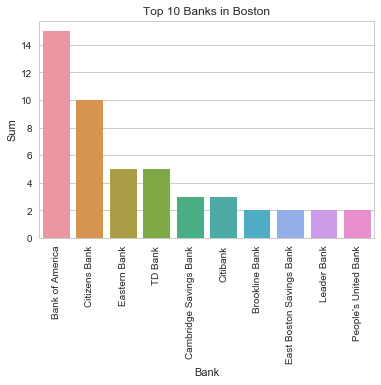

In [39]:
df = pd.read_sql_query('SELECT value,COUNT(*) AS SUM FROM nodes_tags '
'WHERE key= "name" and value LIKE "%Bank%" ' 
'GROUP BY value '
'ORDER BY SUM DESC LIMIT 10 ', disk_engine)

sns.set_style("whitegrid")
plot1= sns.barplot(x="value", y="SUM", data=df)
plot1.set_xticklabels(plot1.get_xticklabels(), rotation=90)

plot1.set(xlabel='Bank', ylabel='Sum')
plot1.set_title('Top 10 Banks in Boston')


### Popular Coffee

In [262]:
query = '''SELECT value,COUNT(*) AS SUM FROM nodes_tags 
WHERE key='name' and value LIKE '%Coffee%' 
GROUP BY value
ORDER BY SUM DESC LIMIT 10

'''
result=cur.execute(query).fetchall()
for a, b in result:
    print a,":", b

Peet's Coffee : 5
Starbucks Coffee : 5
1369 Coffee House : 2
Flat Black Coffee : 2
Starbuck's Coffee : 2
7 Pond Coffee Bar : 1
Andala Coffee House : 1
Bean Towne Coffee House : 1
Blue State Coffee : 1
Blue State Coffee  : 1


Starbucks is the most popular coffee shop in Boston area; there 7 shops (combination of 'Starbucks Coffee' and 'Starbuck's Coffee'), following by Peets's coffee.

### Popular Fast Food

In [282]:
query = ''' SELECT value, COUNT(*)as SUM FROM nodes_tags, (SELECT DISTINCT(id) FROM nodes_tags WHERE value= 'fast_food') as sub
WHERE nodes_tags.id=sub.id and key='name'
Group by nodes_tags.value
Order by SUM DESC LIMIT 10;'''

result=cur.execute(query).fetchall()
for a, b in result:
    print a,':',b


Dunkin' Donuts : 12
Subway : 11
McDonald's : 8
Burger King : 7
Wendy's : 5
Anna's Taqueria : 3
Chipotle : 3
Domino's : 3
Sbarro : 3
Boloco : 2


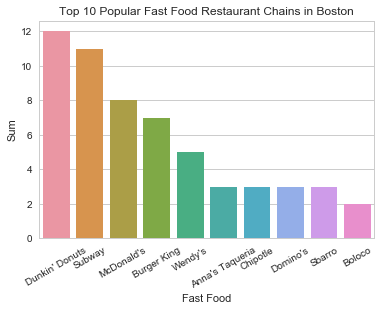

In [40]:
df = pd.read_sql_query(
    'SELECT value, COUNT(*)as SUM FROM nodes_tags, (SELECT DISTINCT(id) FROM nodes_tags WHERE value= "fast_food") as sub '
'WHERE nodes_tags.id=sub.id and key="name" '
'Group by nodes_tags.value '
' Order by SUM DESC LIMIT 10;', disk_engine)

sns.set_style("whitegrid")
plot1= sns.barplot(x="value", y="SUM", data=df)
plot1.set_xticklabels(plot1.get_xticklabels(), rotation=30)
plot1.set(xlabel='Fast Food', ylabel='Sum')
plot1.set_title('Top 10 Popular Fast Food Restaurant Chains in Boston')


The people in Boston love donuts! 'Dunkin' Donuts'is the largest fast food chains here followed by Subway and McDonald's.   

### Educational Institutions

In [322]:
query1 = ''' SELECT count(*) FROM nodes_tags, 
(SELECT DISTINCT(id) FROM nodes_tags WHERE value ='school') as sub
WHERE nodes_tags.id = sub.id and value LIKE '%High School%'
'''

query2 = ''' SELECT count(*) FROM nodes_tags, 
(SELECT DISTINCT(id) FROM nodes_tags WHERE value ='school') as sub
WHERE nodes_tags.id = sub.id and value LIKE '%Elementary School%'
'''
query3 = ''' SELECT count(*) FROM nodes_tags, 
(SELECT DISTINCT(id) FROM nodes_tags WHERE value ='school') as sub
WHERE nodes_tags.id = sub.id and value LIKE '%preschool%'
'''

query4 = ''' SELECT count(*) FROM nodes_tags, 
(SELECT DISTINCT(id) FROM nodes_tags WHERE value ='school') as sub
WHERE nodes_tags.id = sub.id and value LIKE '%Middle School%'
'''

query5 = ''' SELECT count(*) FROM nodes_tags, 
(SELECT DISTINCT(id) FROM nodes_tags WHERE value ='school') as sub
WHERE nodes_tags.id = sub.id and value LIKE '%college%'
'''

result3= cur.execute(query3).fetchall()
print 'The numbers of Preschools:',result3[0][0] 

result2= cur.execute(query2).fetchall()
print 'The numbers of Elementary Schools:',result2[0][0]

result4= cur.execute(query4).fetchall()
print 'The numbers of Middle Schools:',result4[0][0] 

result1= cur.execute(query1).fetchall()
print 'The numbers of High Schools:',result1[0][0] 

result5= cur.execute(query5).fetchall()
print 'The numbers of colleges:',result5[0][0]


The numbers of Preschools: 3
The numbers of Elementary Schools: 20
The numbers of Middle Schools: 22
The numbers of High Schools: 34
The numbers of colleges: 14


### Data Sources

In [356]:
query = ''' SELECT value, COUNT(*) as num FROM (SELECT * FROM nodes_tags UNION SELECT * FROM ways_tags)
WHERE key ='source' 
GROUP BY value
ORDER BY num DESC LIMIT 10
'''
result=cur.execute(query).fetchall()
print 'top 10 sources:'
for a, b in result:
    print a,':',b
    
#There are too many massgis sources under different name, so let's see except for Massgis, what the other sources are.

query1 = ''' SELECT value, COUNT(*) as num FROM (SELECT * FROM nodes_tags UNION SELECT * FROM ways_tags)
WHERE key ='source'and NOT value LIKE '%massgis_import%'and Not value LIKE '%MassGIS%'
GROUP BY value
ORDER BY num DESC LIMIT 10
'''
result1=cur.execute(query1).fetchall()

print ''
print 'the sources other than "massgis":'
for a, b in result1:
    print a,':',b
    

top 10 sources:
massgis_import_v0.1_20071008193615 : 53464
massgis_import_v0.1_20071009092358 : 11793
massgis_import_v0.1_20071009101959 : 8627
massgis_import_v0.1_20071009091249 : 6141
massgis_import_v0.1_20071009091627 : 5784
massgis_import_v0.1_20071009102616 : 4583
massdot_import_081211 : 4534
Bing : 3190
massgis_import_v0.1_20071009092815 : 2885
massgis_import_v0.1_20071009094650 : 2580

the sources other than "massgis":
massdot_import_081211 : 4534
Bing : 3190
USGS Geonames : 692
DEP Wetlands (1:12,000) - April 2007 (http://www.mass.gov/mgis/wetdep.htm) : 688
survey : 209
Yahoo : 143
bing : 98
county_import_v0.1 : 92
PGS : 81
massdot_import_081511 : 70


MassGis is the largest source of the map.
Some other sources that most people are familiar with include 'Bing' and 'Yahoo'.